In [77]:
import cirq
import math
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

from sympy import isprime
import random
from fractions import Fraction

import psutil
from IPython.display import clear_output
from threading import Thread
import pandas as pd

from datetime import datetime
import numpy as np
import time


In [78]:
from my_functions import *

In [79]:
def initiate_qc(N):
    # identify n-length and m-length
    n_len, m_len = get_nlen_mlen(N)
    
    # Create qubits
    counting_qubits = [cirq.LineQubit(i) for i in range(m_len)]
    auxiliary_qubits = [cirq.LineQubit(i + m_len) for i in range(n_len)]
    
    # Create a circuit
    qc = cirq.Circuit()
    
    # Initialize counting qubits in state |+>
    for qubit in counting_qubits:
        qc.append(cirq.H(qubit))

    # Initialize auxiliary qubits in state |1>
    qc.append(cirq.X(auxiliary_qubits[0]))
    
    qc.append(cirq.I.on_each(auxiliary_qubits[1:]))

    return qc

def append_c_amodN(qc, a, N):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    auxiliary_qubits = qubits[m_len:]
    
    for q in range(m_len):
        pwr = 2**q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc.append(cirq.CX(counting_qubits[q], auxiliary_qubits[i]))
    
    return qc

def append_IQFT(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    
    qc.append(cirq.inverse(cirq.qft(*counting_qubits)))
    return qc
        
def append_measurements(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    
    qc.append(cirq.measure(*counting_qubits, key='result'))
    return qc

def simulation(qc, N, shots=1000):
    _, m_len = get_nlen_mlen(N)
    # Create a simulator
    simulator = cirq.Simulator()
    
    start_time = time.time()
    
    # Simulate the circuit
    result = simulator.run(qc, repetitions=shots)
    
    # End timing
    end_time = time.time()
    
    print(f'## Duration(Simulation): {end_time - start_time:0.02f} sec')

    # Get the measurement results
    counts = result.histogram(key='result')
    
    # Convert to a list of unique results
    unique_results = list(counts.keys())
    
    return [format(v, f'0{m_len}b')[::-1] for v in unique_results]

def shor_qc(a, N, display=False, shots=1):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    qc = append_c_amodN(qc, a, N)
    qc = append_IQFT(qc, N)
    qc = append_measurements(qc)
    
    if display:
        print(qc)
        display(SVGCircuit(qc))
    
    return qc

           ┌──┐
0: ────H────@─────@───────qft^-1───M('result')───
            │     │       │        │
1: ────H────┼@────┼───@───#2───────M─────────────
            ││    │   │   │        │
2: ────H────┼┼────┼───┼───#3───────M─────────────
            ││    │   │   │        │
3: ────H────┼┼────┼───┼───#4───────M─────────────
            ││    │   │   │        │
4: ────H────┼┼────┼───┼───#5───────M─────────────
            ││    │   │   │        │
5: ────H────┼┼────┼───┼───#6───────M─────────────
            ││    │   │   │        │
6: ────H────┼┼────┼───┼───#7───────M─────────────
            ││    │   │   │        │
7: ────H────┼┼────┼───┼───#8───────M─────────────
            ││    │   │
8: ────X────┼┼────┼───┼──────────────────────────
            ││    │   │
9: ────I────┼X────┼───┼──────────────────────────
            │     │   │
10: ───I────X─────┼───┼──────────────────────────
                  │   │
11: ───I──────────X───X──────────────────────────
           └──┘


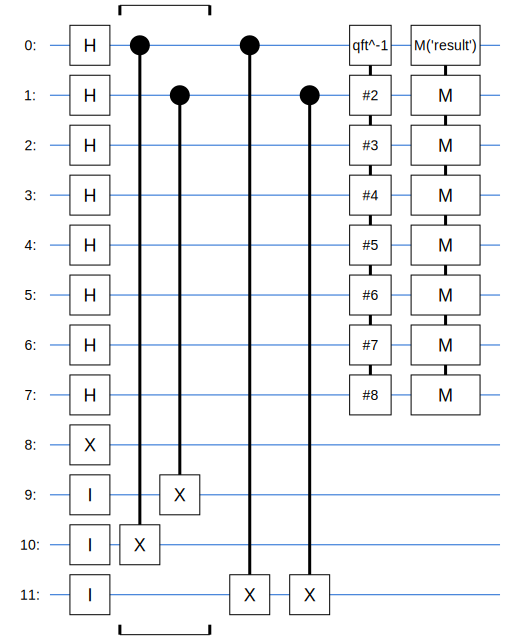

In [81]:
# Example usage
N = 15  # Example value
a = 2  # Example value


qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
qc = append_IQFT(qc, N)
qc = append_measurements(qc, N)

print(qc)
display(SVGCircuit(qc))
# print(simulation(qc, N))


In [57]:
def test_shor_circuit(N, verbose=True, shots=1):
    def vprint(message):
        if verbose:
            print(message)

    FACTOR_FOUND = False
    ATTEMPT = 0

    # validate_N(N)  # no need to validate N value
    start_time = datetime.now()

    n_len, m_len = get_nlen_mlen(N)

    while not FACTOR_FOUND:
        ATTEMPT = 0
        for a in range(2,N):
            if math.gcd(a,N)==1:
                ATTEMPT += 1
                _txt = f'\n[a = {a}]'
                vprint(f"{_txt}\n{'-'*len(_txt)}")
                vprint(f"ATTEMPT {ATTEMPT}:")

                qc = shor_qc(a, N)
                readings = simulation(qc, N, shots=shots)
                two_power_mlen = 2**m_len

                for reading in readings:
                    int_reading = int(reading, 2)
                    vprint(f"\nRegister Reading: {reading} [{int_reading}]")
                    phase = int_reading/two_power_mlen
                    frac = Fraction(phase).limit_denominator(N)
                    r = frac.denominator
                    vprint(f"Corresponding Phase: [{int_reading}/{two_power_mlen}] >>> {phase:0.5f} >>> {frac}")

                    vprint(f"Result: r = {r}")

                    if not check_r_condition(a, r, N):
                        vprint(f"[{r}] did not pass r conditions")
                        continue

                    if phase != 0:
                        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                        half_r = r//2
                        a_power_half_r = pow(a, half_r,N)
                        guesses = [math.gcd(a_power_half_r-1, N), math.gcd(a_power_half_r+1, N)]
                        vprint(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                        for guess in guesses:
                            if guess not in [1,N] and (N % guess) == 0:
                                # Guess is a factor!
                                print(f"*** Non-trivial factor found: {guess} ***")
                                FACTOR_FOUND = True

                    if FACTOR_FOUND:
                        break

            else:
                vprint(f'\n# [a={a}] is not an accepted value! #')

            if FACTOR_FOUND:
                break

        if not FACTOR_FOUND:
            vprint('\nALL VALID A VALUES ARE USED !')
            FACTOR_FOUND = True



            # Record the end time
    end_time = datetime.now()

    # Calculate the duration
    duration = end_time - start_time
    # Format the duration to exclude microseconds
    formatted_duration = str(duration).split('.')[0]


    print(f"""
    ------------{'-'*len(str(ATTEMPT))}--
    # ATTEMPT = {ATTEMPT} #
    -------------{'-'*len(formatted_duration)}--
    # Duration = {formatted_duration} #
    -------------{'-'*len(formatted_duration)}--
    """)

    stop_flag_path = "stop_monitoring.flag"
    # Create the stop flag file
    with open(stop_flag_path, 'w') as f:
        f.write('stop')


In [45]:
# N = generate_N()
N = 143

test_shor_circuit(N)


[a = 2]
--------
ATTEMPT 1:

Register Reading: 0100100011110000 [18672]
Corresponding Phase: [18672/65536] >>> 0.28491 >>> 39/137
Result: r = 137
[137] did not pass r conditions

[a = 3]
--------
ATTEMPT 2:

Register Reading: 0101100101100100 [22884]
Corresponding Phase: [22884/65536] >>> 0.34918 >>> 22/63
Result: r = 63
[63] did not pass r conditions

[a = 4]
--------
ATTEMPT 3:

Register Reading: 1101010111001010 [54730]
Corresponding Phase: [54730/65536] >>> 0.83511 >>> 76/91
Result: r = 91
[91] did not pass r conditions

[a = 5]
--------
ATTEMPT 4:

Register Reading: 1011010101101101 [46445]
Corresponding Phase: [46445/65536] >>> 0.70869 >>> 90/127
Result: r = 127
[127] did not pass r conditions

[a = 6]
--------
ATTEMPT 5:

Register Reading: 0101111000011110 [24094]
Corresponding Phase: [24094/65536] >>> 0.36765 >>> 25/68
Result: r = 68
Guessed Factors: 1 and 1

[a = 7]
--------
ATTEMPT 6:

Register Reading: 1000111100001000 [36616]
Corresponding Phase: [36616/65536] >>> 0.55872 

# 1# N = 15 = 3 * 5

In [67]:
N = 15
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.03 sec
*** Non-trivial factor found: 3 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:00 #
    ----------------------
    


# 2# N = 35 = 5 * 7

In [68]:
N = 35
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.30 sec
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:00 #
    ----------------------
    


# 3# N = 77 = 7 * 11

In [69]:
N = 77
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 1.23 sec
*** Non-trivial factor found: 7 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:01 #
    ----------------------
    


# 4# N = 143 = 11 * 13

In [70]:
N = 143
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 7.61 sec
*** Non-trivial factor found: 11 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:07 #
    ----------------------
    


# 5# N = 221 = 13 * 17

In [71]:
N = 221
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 8.26 sec
*** Non-trivial factor found: 13 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:08 #
    ----------------------
    


# 6# N = 323 = 17 * 19

In [75]:
N = 323
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 113.18 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:53 #
    ----------------------
    


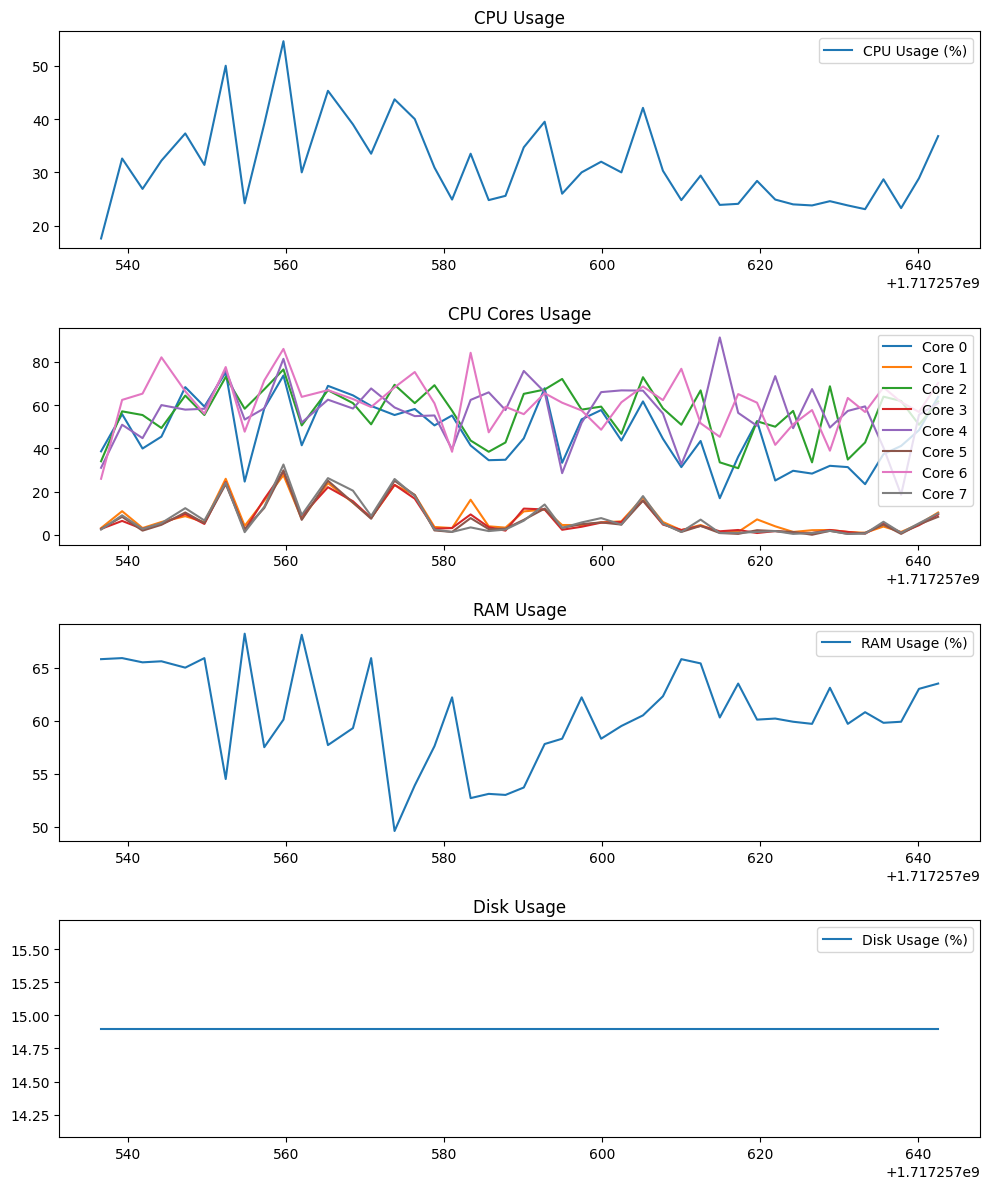

# 7# N = 437 = 19 * 23

In [73]:
N = 437
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 101.84 sec
*** Non-trivial factor found: 19 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:41 #
    ----------------------
    


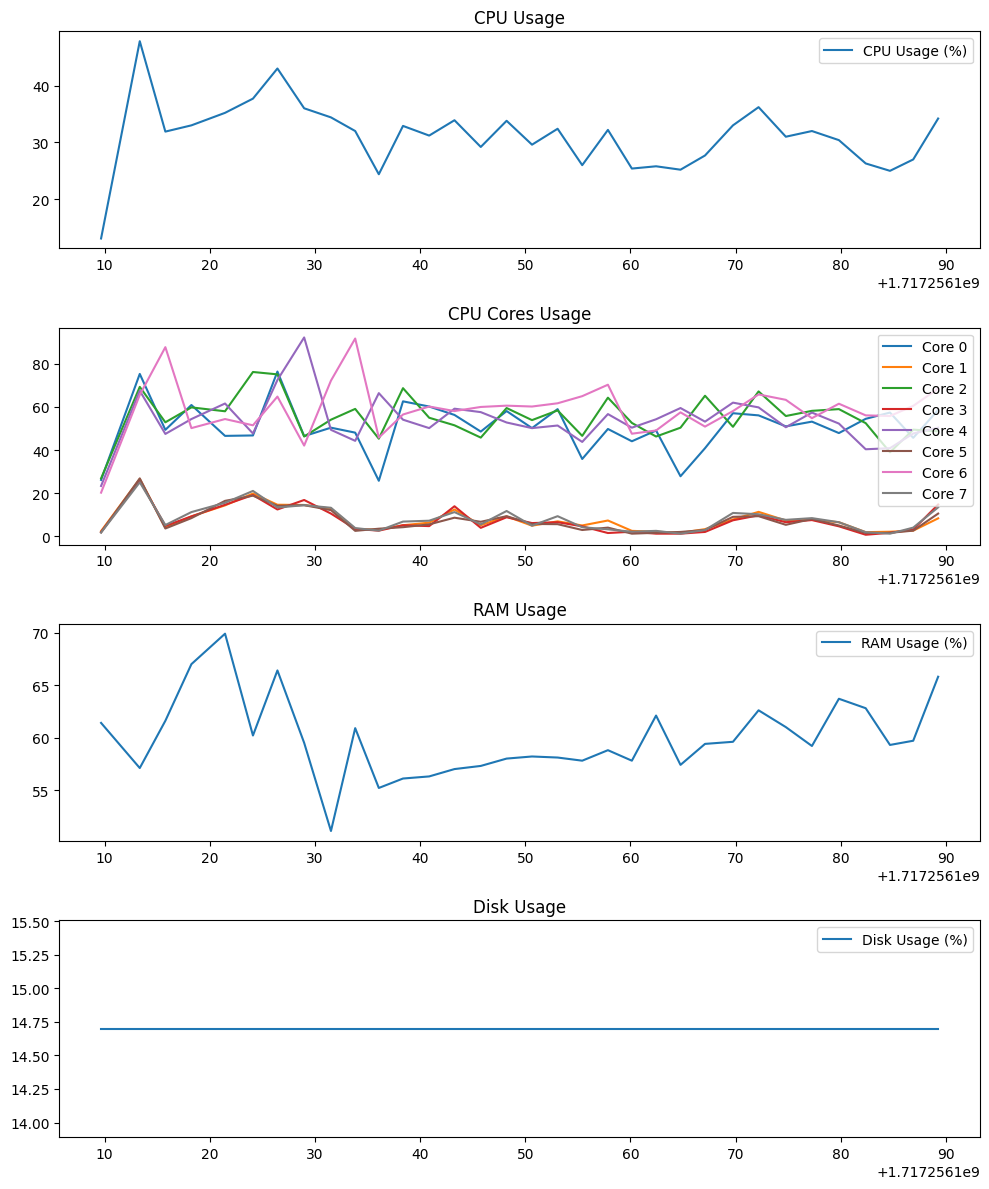

# 8# N = 667 = 23 * 29

In [74]:
N = 667
test_shor_circuit(N, verbose=False, shots=100)

KeyboardInterrupt: 

In [40]:
dur = [15,15,22]
att = [2,2,3]
round(np.mean(dur)/np.mean(att))

7

In [56]:
for i in range(1,10):
    print(f'# {i}# N = {prime_100[i]*prime_100[i+1]} = {prime_100[i]} * {prime_100[i+1]}')

# 1# N = 15 = 3 * 5
# 2# N = 35 = 5 * 7
# 3# N = 77 = 7 * 11
# 4# N = 143 = 11 * 13
# 5# N = 221 = 13 * 17
# 6# N = 323 = 17 * 19
# 7# N = 437 = 19 * 23
# 8# N = 667 = 23 * 29
# 9# N = 899 = 29 * 31


In [ ]:
N=15, N=35, N=77, N=143, N=221, N=323, N=437, and N=667

In [46]:
127/3

42.333333333333336

In [47]:
2**42

4398046511104

In [51]:
math.log2(4397987791019)

41.99998073787061

In [50]:
43*3

129